# **NLP FOR MOVIE GENRE CLASSIFICATION**

---

###**PERSONAL IDENTITY**

Nama : Mukhamad Azis Tholib \
Email: mukhamadazistholib278@gmail.com



###**DOWNLOAD DATASET FROM KAGGLE**

In [20]:
# kaggle instalation package

!pip install -q kaggle

In [21]:
# upload kaggle.json

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mukhamadazistholib","key":"08bda164beac87e49af77c49b0bd592f"}'}

In [22]:
# make directory and change permission for kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [23]:
# download dataset with 'copy api command' from kaggle

!kaggle datasets download -d lokkagle/movie-genre-data

 53% 5.00M/9.46M [00:00<00:00, 18.8MB/s]
100% 9.46M/9.46M [00:00<00:00, 30.6MB/s]


In [24]:
# unzip dataset
!mkdir moviegenredata
!unzip movie-genre-data.zip -d moviegenredata
!ls moviegenredata

Archive:  movie-genre-data.zip
  inflating: moviegenredata/kaggle_movie_train.csv  
kaggle_movie_train.csv


### **LOAD DATASET**

IMPORT LIBRARY

In [31]:
# import pandas
import pandas as pd
import re


# for split data model
from sklearn.model_selection import train_test_split

# for preprocessing and layer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# for plot visualization
import matplotlib.pyplot as plt

In [32]:
# load dataset

df = pd.read_csv('moviegenredata/kaggle_movie_train.csv')
df.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


### **CHECKING THE NUMBER OF VALUE IN EACH GENRE**

In [33]:
# checking the number of values

df['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

only choose a few genres from the dataset such as action, comedy, sci-fi and horror

In [34]:
# deleting genre data that is not included in the selection

df = df[~df['genre'].isin(['drama','thriller','other','adventure','romance'])]
df['genre'].value_counts()

comedy    2941
action    2392
sci-fi     613
horror     456
Name: genre, dtype: int64

In [35]:
# deleting special characters in the text field

df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))

# droping the old id and text columns
df = df.drop(['id', 'text'], axis=1)
df.head()

,genre,Text
1,comedy,t summa cum laude and all And I m about to lau...
9,action,e reels as the world spins Sweat pours off him...
20,comedy,I say he s a man who ll go far Some people sa...
25,comedy,you find out where the bachelor party is COLE ...
29,comedy,ibly horrendous public break up on the quad Ag...


In [36]:
# genre labelization

genre = pd.get_dummies(df.genre)
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

,Text,action,comedy,horror,sci-fi
1,t summa cum laude and all And I m about to lau...,0,1,0,0
9,e reels as the world spins Sweat pours off him...,1,0,0,0
20,I say he s a man who ll go far Some people sa...,0,1,0,0
25,you find out where the bachelor party is COLE ...,0,1,0,0
29,ibly horrendous public break up on the quad Ag...,0,1,0,0


In [37]:
# change the data type to str and numpy array

text = df_genre['Text'].astype(str)
label = df_genre[['action', 'comedy','horror','sci-fi']].values

### **VALIDATION SET OF 20% OF THE TOTAL DATASET**

In [38]:
# splitting dataset 20% test/validation

genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

### **TOKENIZER**

In [39]:
# seq conversion

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train) 
tokenizer.fit_on_texts(genre_test)
 
sekuens_train = tokenizer.texts_to_sequences(genre_train)
sekuens_test = tokenizer.texts_to_sequences(genre_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

### **EMBEDDING AND LSTM**

In [40]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [41]:
# model compiile using Adam optimizer

Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [44]:
# callback for acc and acc_val upper than 90%

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nThe train and validation accuracy obtained has reached the value of > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

### **DATA TRAIN**

In [45]:
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
161/161 - 19s - loss: 0.0199 - accuracy: 0.9943 - val_loss: 0.6583 - val_accuracy: 0.8743
Epoch 2/30
161/161 - 19s - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.6406 - val_accuracy: 0.8891
Epoch 3/30
161/161 - 19s - loss: 0.0934 - accuracy: 0.9699 - val_loss: 0.7983 - val_accuracy: 0.8329
Epoch 4/30
161/161 - 19s - loss: 0.0626 - accuracy: 0.9844 - val_loss: 0.5232 - val_accuracy: 0.8938
Epoch 5/30
161/161 - 19s - loss: 0.0216 - accuracy: 0.9947 - val_loss: 0.7403 - val_accuracy: 0.8720
Epoch 6/30
161/161 - 19s - loss: 0.0431 - accuracy: 0.9854 - val_loss: 0.6457 - val_accuracy: 0.8493
Epoch 7/30
161/161 - 19s - loss: 0.0524 - accuracy: 0.9857 - val_loss: 0.7147 - val_accuracy: 0.8665
Epoch 8/30
161/161 - 19s - loss: 0.0430 - accuracy: 0.9895 - val_loss: 0.6861 - val_accuracy: 0.8259
Epoch 9/30
161/161 - 19s - loss: 0.0251 - accuracy: 0.9941 - val_loss: 0.5843 - val_accuracy: 0.8985
Epoch 10/30
161/161 - 19s - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.5935 - val_accura

### **PLOTTING ACC AND LOSS**

**ACCURACY**

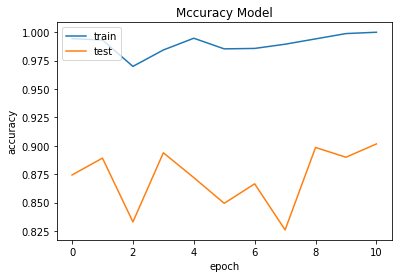

In [47]:
# plot accuracy 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Mccuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**LOSS**

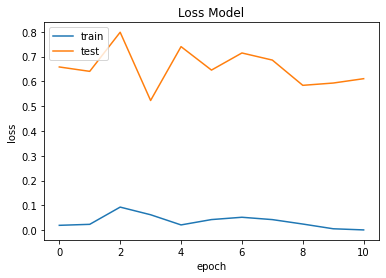

In [48]:
# plot loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dataset source:\
https://www.kaggle.com/lokkagle/movie-genre-data
